In [1]:
# Necessary imports
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw

%matplotlib inline

## I/O Functions

In [2]:
def read_xy(file):
    
    with open(file, "r") as fp:
        fp_line = fp.read().split("\n")[:-1]
    
    points = np.array([line.split() for line in fp_line]).astype(float)
    # center all points
    centroid = (points.mean(0)).reshape((1, -1))
    points = points - centroid
    # normalize shape length
    length = (points.max(0) - points.min(0)).max() / 150.
    normalized_pts = (points / length).astype(int) + 128
    
    return normalized_pts

## Visualization Functions 

In [3]:
def plot_polygon(poly_verts, size = 8):
    
    img = Image.new('L', (256, 256))
    ImageDraw.Draw(img).polygon(points.reshape((-1, )).tolist(), outline = 'blue', fill = 'white')
    
    plt.figure(figsize = (size, size))
    plt.imshow(img, cmap='gray')
    plt.plot()

In [4]:
def plot_signed_distance_field(dist_map, poly_verts, size = 8):
    
    pos_dist_map = dist_map - dist_map.min()
    img_dist = Image.fromarray(np.uint8(pos_dist_map / pos_dist_map.max() * 255) , 'L')
    ImageDraw.Draw(img_dist).polygon(poly_verts.reshape((-1, )).tolist(), outline = 'blue', fill = None)

    plt.figure(figsize = (size, size))
    plt.imshow(img_dist)
    plt.plot()

In [5]:
def plot_offset(offset, size = 8):
    
    img_dist = Image.fromarray(np.uint8(offset * 255) , 'L')

    plt.figure(figsize = (size, size))
    plt.imshow(img_dist, cmap = 'gray')
    plt.plot()

## Geometric Functions

### Intersection between segments

In [6]:
def ccw(A, B, C):
    return (C[1] - A[1]) * (B[0] - A[0]) > (B[1] - A[1]) * (C[0] - A[0])

# Return true if line segments AB and CD intersect
def intersect_point_segment(A, B, C, D):
    return ccw(A, C, D) != ccw(B, C, D) and ccw(A, B, C) != ccw(A, B, D)

In [7]:
def ccw_matrix(A, B, C):
    
    return (C[:, 1] - A[:, 1]) * (B[:, 0] - A[:, 0]) > (B[:, 1] - A[:, 1]) * (C[:, 0] - A[:, 0])

def intersect_matrix_segment(A, mat_b, C, D): # only B is matrix
    
    num = mat_b.shape[0]
    mat_a = np.tile(A.reshape((1, -1)), (num, 1))
    mat_c = np.tile(C.reshape((1, -1)), (num, 1))
    mat_d = np.tile(D.reshape((1, -1)), (num, 1))
    
    return np.logical_and(np.logical_xor(ccw_matrix(mat_a, mat_c, mat_d), ccw_matrix(mat_b, mat_c, mat_d)), 
                          np.logical_xor(ccw_matrix(mat_a, mat_b, mat_c), ccw_matrix(mat_a, mat_b, mat_d)))

### Distance Functions

In [8]:
def distance_from_point_to_segment(query, seg_a, seg_b):
    
    vec_qa = query - seg_a
    vec_ba = seg_b - seg_a
    
    dot_prod = (vec_qa * vec_ba).sum()
    len_ba = (vec_ba * vec_ba).sum()
    
    lambd = dot_prod / len_ba
    
    if lambd <= 0:
        return np.linalg.norm(query - seg_a)
    elif lambd >= 1:
        return np.linalg.norm(query - seg_b)
    else:
        proj = seg_a + lambd * vec_ba
        return np.linalg.norm(query - proj)

In [9]:
def distance_from_matrix_to_segment(points, seg_a, seg_b):
    
    mat_qa = points - seg_a
    vec_ba = (seg_b - seg_a).reshape((1, -1))
    
    dot_prod = (mat_qa * vec_ba).sum(1)
    len_ba = (vec_ba * vec_ba).sum()
    
    lambd = dot_prod / len_ba
    dists = np.zeros_like(lambd)
    
    indices_0 = (lambd <= 0)
    indices_1 = (lambd >= 1)
    indices_2 = np.logical_and(np.logical_not(indices_0), np.logical_not(indices_1))
    
    dists[indices_0] = np.linalg.norm(points[indices_0] - seg_a, axis = 1)
    dists[indices_1] = np.linalg.norm(points[indices_1] - seg_b, axis = 1)
    dists[indices_2] = np.linalg.norm(points[indices_2] - seg_a - lambd[indices_2].reshape((-1, 1)) * vec_ba, axis = 1)
    
    return dists.reshape((-1, 1))

### Distance Oracle

In [10]:
class DistanceQuery:
    
    def __init__(self):
        self.poly_verts = []
        self.size = 0
        
    def is_init(self):
        
        return True if self.size > 0 else False
        
    def update(self, poly_verts):
        self.poly_verts = poly_verts
        self.size = poly_verts.shape[0]
        
    def distance(self, query):
        min_dist = 1e10
        count = 0
        for i in range(self.size):
            dist = distance_from_point_to_segment(query, self.poly_verts[i], self.poly_verts[(i + 1) % self.size])
            min_dist = min(dist, min_dist)
            if intersect_point_segment([0, 0], query, self.poly_verts[i], self.poly_verts[(i + 1) % self.size]):
                count += 1
                
        if count % 2 == 1:
            min_dist = -min_dist
        
        return min_dist
    
    def distance_matrix(self, query_mat):
        min_dists = []
        min_count = np.zeros((query_mat.shape[0], 1))
        
        for i in range(self.size):
            dist = distance_from_matrix_to_segment(query_mat, 
                                                   self.poly_verts[i], 
                                                   self.poly_verts[(i + 1) % self.size])
            min_dists.append(dist)
            
            count = intersect_matrix_segment(np.array([0, 0]), query_mat, 
                                             self.poly_verts[i], 
                                             self.poly_verts[(i + 1) % self.size])
            min_count = min_count + count.reshape((-1, 1))
            
        min_dists = np.hstack(min_dists).min(1)
        flag_neg = np.squeeze(min_count % 2 == 1)
        min_dists[flag_neg] = -min_dists[flag_neg]
        
        return min_dists

## Main Function

Read polygon...

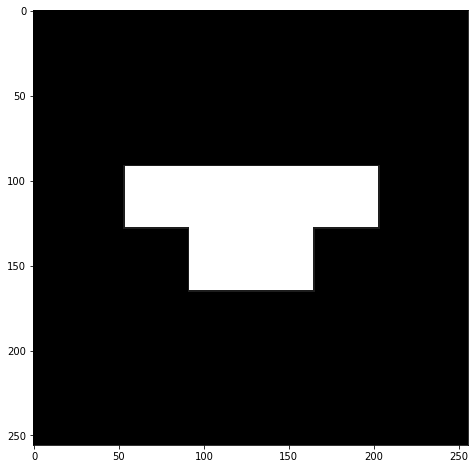

In [11]:
points = read_xy("data/stacked_box.xy")
plot_polygon(points)

Compute signed distance function...

In [12]:
dist_oracle = DistanceQuery()
dist_oracle.update(points)

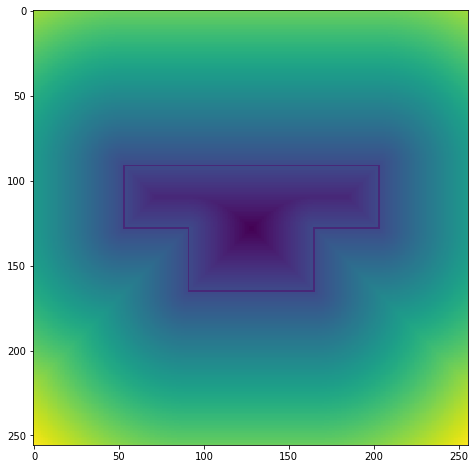

In [13]:
xx, yy = np.meshgrid(range(256), range(256))
mat = np.hstack((xx.reshape((-1, 1)), yy.reshape((-1, 1))))
dist_map = dist_oracle.distance_matrix(mat).reshape((256, 256))

plot_signed_distance_field(dist_map, points)

Compute single offset polygon...

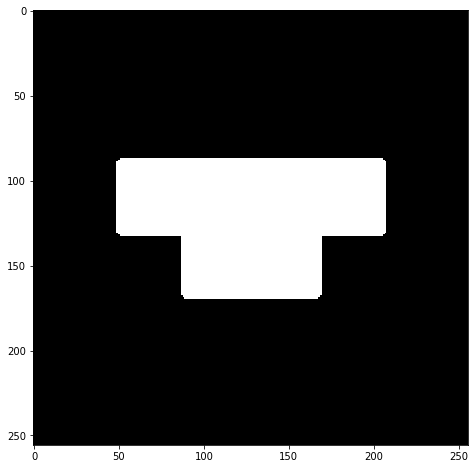

In [14]:
single_offset = (dist_map < 5).astype(int)
plot_offset(single_offset)